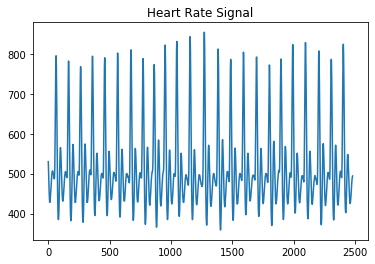

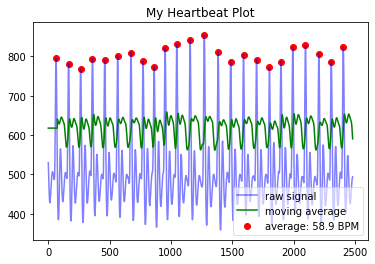

bpm: 58.898847631242
RR_list: [1020.0, 990.0, 960.0, 1000.0, 1050.0, 1090.0, 990.0, 900.0, 900.0, 950.0, 1080.0, 1160.0, 1130.0, 1020.0, 1050.0, 1060.0, 1050.0, 940.0, 970.0, 1030.0, 1090.0, 1020.0, 980.0]
RR_diff: [30.0, 40.0, 50.0, 40.0, 100.0, 90.0, 0.0, 50.0, 130.0, 80.0, 30.0, 110.0, 30.0, 10.0, 10.0, 110.0, 30.0, 60.0, 60.0, 70.0, 40.0] 
RR_sqdiff: [900.0, 1600.0, 2500.0, 1600.0, 10000.0, 8100.0, 0.0, 2500.0, 16900.0, 6400.0, 900.0, 12100.0, 900.0, 100.0, 100.0, 12100.0, 900.0, 3600.0, 3600.0, 4900.0, 1600.0]
IBI: 1018.695652173913
SDNN: 65.76006108019
SDSD: 35.26382586966403
RMSSD: 65.93647736738025
pNN20: 0.8571428571428571 
pNN50: 0.42857142857142855


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
measures = {}
def get_data(filename):
    dataset = pd.read_csv(filename)
    return dataset
def rolmean(dataset, hrw, fs):
    mov_avg = dataset['heart'].rolling(int(hrw*fs)).mean()
    avg_hr = (np.mean(dataset.heart))
    mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
    mov_avg = [x*1.2 for x in mov_avg]
    dataset['hart_rollingmean'] = mov_avg
def detect_peaks(dataset):
    window = []
    peaklist = []
    listpos = 0
    for datapoint in dataset.heart:
        rollingmean = dataset.hart_rollingmean[listpos]
        if (datapoint < rollingmean) and (len(window) < 1):
            listpos += 1
        elif (datapoint > rollingmean):
            window.append(datapoint)
            listpos += 1
        else:
            maximum = max(window)
            beatposition = listpos - len(window) + (window.index(max(window)))
            peaklist.append(beatposition)
            window = []
            listpos += 1
    measures['peaklist'] = peaklist
    measures['ybeat'] = [dataset.heart[x] for x in peaklist]
def calc_RR(dataset, fs):
    RR_list = []
    peaklist = measures['peaklist']
    cnt = 0
    while (cnt < (len(peaklist)-1)):
        RR_interval = (peaklist[cnt+1] - peaklist[cnt])
        ms_dist = ((RR_interval / fs) * 1000.0)
        RR_list.append(ms_dist)
        cnt += 1
    measures['RR_list'] = RR_list
def calc_bpm():
    RR_list = measures['RR_list']
    measures['bpm'] = 60000 / np.mean(RR_list)
def plotter(dataset, title):
    peaklist = measures['peaklist']
    ybeat = measures['ybeat']
    plt.title(title)
    plt.plot(dataset.heart, alpha=0.5, color='blue', label="raw signal")
    plt.plot(dataset.hart_rollingmean, color ='green', label="moving average")
    plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %measures['bpm'])
    plt.legend(loc=4, framealpha=0.6)
    plt.show()
def process(dataset, hrw, fs): #Remember; hrw was the one-sided window size (we used 0.75) and fs was the sample rate (file is recorded at 100Hz)
    rolmean(dataset, hrw, fs)
    detect_peaks(dataset)
    calc_RR(dataset, fs)
    calc_bpm()
    plotter(dataset, "My Heartbeat Plot")

dataset = get_data("data.csv")
plt.title("Heart Rate Signal") #The title of our plot
plt.plot(dataset.heart) #Draw the plot object
plt.show()
process(dataset, 0.75, 100)
#We have imported our Python module as an object called 'hb'
#This object contains the dictionary 'measures' with all values in it
#Now we can also retrieve the BPM value (and later other values) like this:
bpm = measures['bpm']
print("bpm:",bpm)
#To view all objects in the dictionary, use "keys()" like so:
#print (measures.keys())

RR_diff = []
RR_sqdiff = []
RR_list = measures['RR_list']
print("RR_list:",RR_list)
cnt = 1 #Use counter to iterate over RR_list
while (cnt < (len(RR_list)-1)): #Keep going as long as there are R-R intervals
    RR_diff.append(abs(RR_list[cnt] - RR_list[cnt+1])) #Calculate absolute difference between successive R-R interval
    RR_sqdiff.append(math.pow(RR_list[cnt] - RR_list[cnt+1], 2)) #Calculate squared difference
    cnt += 1
print ("RR_diff:",RR_diff,"\nRR_sqdiff:", RR_sqdiff)
ibi = np.mean(RR_list) #Take the mean of RR_list to get the mean Inter Beat Interval
print ("IBI:", ibi)
sdnn = np.std(RR_list) #Take standard deviation of all R-R intervals
print ("SDNN:", sdnn)
sdsd = np.std(RR_diff) #Take standard deviation of the differences between all subsequent R-R intervals
print ("SDSD:", sdsd)
rmssd = np.sqrt(np.mean(RR_sqdiff)) #Take root of the mean of the list of squared differences
print ("RMSSD:", rmssd)
nn20 = [x for x in RR_diff if (x>20)] #First create a list of all values over 20, 50
nn50 = [x for x in RR_diff if (x>50)]
pnn20 = float(len(nn20)) / float(len(RR_diff)) #Calculate the proportion of NN20, NN50 intervals to all intervals
pnn50 = float(len(nn50)) / float(len(RR_diff)) #Note the use of float(), because we don't want Python to think we want an int() and round the proportion to 0 or 1
print ("pNN20:", pnn20,"\npNN50:", pnn50)
